## Initial Setup

### Import necessary libraries

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import py7zr
import os
from scipy.fft import fft, fftfreq
from scipy.signal import welch
from rpca import RPCA

### Decompress the .mat file if it is compressed

Following patient data and its quality:
- `S1.mat` $\rightarrow$ good patient data
- `S3.mat` $\rightarrow$ good patient data
- `S31.mat` $\rightarrow$ good patient data
- `S32.mat` $\rightarrow$ good patient data
- `S19.mat` $\rightarrow$ medium patient data
- `S29.mat` $\rightarrow$ bad patient data

In [ ]:
subject = 1

# Path to the compressed file
compressed_file = f'./data/S{subject}.mat.7z'
mat_file = f'./data/S{subject}.mat'

# Check if the .mat file already exists
if os.path.exists(mat_file):
    print(f"Using existing file {mat_file}")
# Check if the compressed file exists
elif os.path.exists(compressed_file):
    # Extract the file
    with py7zr.SevenZipFile(compressed_file, mode='r') as z:
        z.extractall()
    print(f"Successfully extracted {compressed_file}")
else:
    print(f"File {compressed_file} not found")

Using existing file S1.mat


### Load the .mat file

In [3]:
# S1.mat # good patient data
# S3.mat # good patient data
# S19.mat # medium patient data
# S29.mat # bad patient data
# S31.mat # good patient data
# S32.mat # good patient data

eeg_data = sio.loadmat(mat_file)['data']
print(eeg_data.shape)

(64, 1500, 40, 6)


### Define useful global variables

In [4]:
frequency_to_index = {
    8: 0, 9: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6, 15: 7,
    8.2: 8, 9.2: 9, 10.2: 10, 11.2: 11, 12.2: 12, 13.2: 13, 14.2: 14, 15.2: 15,
    8.4: 16, 9.4: 17, 10.4: 18, 11.4: 19, 12.4: 20, 13.4: 21, 14.4: 22, 15.4: 23,
    8.6: 24, 9.6: 25, 10.6: 26, 11.6: 27, 12.6: 28, 13.6: 29, 14.6: 30, 15.6: 31,
    8.8: 32, 9.8: 33, 10.8: 34, 11.8: 35, 12.8: 36, 13.8: 37, 14.8: 38, 15.8: 39,
}

samples = 250 # 250 samples analyzed at once
spacing = 4  # time between samples in ms
fs = 250  # 250 Hz sampling rate


time_range = np.linspace(0, samples * spacing, samples)
freq_range = fftfreq(samples, spacing)[: samples // 2] * 1000
default_freq_xlim = [5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35]

# Define all available channels with their corresponding indices
relevant_channels = {
    ### Secondary electrodes
    "FCz":18,
    "C5": 24,
    "C3": 25,
    "C1": 26,
    "C2": 28,
    "C4": 29,
    "C6": 30,
    "CPz": 37,
    "P7": 43,
    "P5": 44,
    "P3": 45,
    "P1": 46,
    "P2": 48,
    "P4": 49,
    "P6": 50,
    "P8": 51,

    ### Best electrodes
    ## Frontal
    "Cz": 27,
    
    ## Parietal
    "Pz": 47,
    
    ## Parieto-occipital
    "PO7": 52,
    "PO5": 53,
    "PO3": 54,
    
    "POz": 55,

    "PO4": 56,
    "PO6": 57,
    "PO8": 58,

    ## Occipital
    "O1": 60,
    "Oz": 61,
    "O2": 62,
}

# Electrode sets with number of electrodes as key and channel name/index dict as value
channels_sets = {
    4:  {ch: relevant_channels[ch] for ch in ["POz", "O1", "Oz", "O2"]},
    8:  {ch: relevant_channels[ch] for ch in ["PO5", "PO3", "POz", "PO4", "PO6", "O1", "Oz", "O2"]},
    9:  {ch: relevant_channels[ch] for ch in ["Pz", "PO5", "PO3", "POz", "PO4", "PO6", "O1", "Oz", "O2"]},
    12: {ch: relevant_channels[ch] for ch in ["Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    14: {ch: relevant_channels[ch] for ch in ["P3", "P4", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    16: {ch: relevant_channels[ch] for ch in ["P3", "P1", "P2", "P4", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    18: {ch: relevant_channels[ch] for ch in ["P5", "P3", "P1", "P2", "P4", "P6", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
    20: {ch: relevant_channels[ch] for ch in ["P7", "P5", "P3", "P1", "P2", "P4", "P6", "P8", "Cz", "Pz", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "O1", "Oz", "O2"]},
}

selected_channels = channels_sets[9]

most_relevant_channels = {
    # "Pz": 47,
    "POz": 55,
    # For most individuals
    "O1": 60,
    "Oz": 61,
    "O2": 62,
}


# mu and lambda values used for the best results
trial = 4
evoked_frequency = 8
start_sample = 375 # 1.5 second after the trial start
end_sample = 625 # 2.5 seconds after the trial start

# variables used for BCI experiments
evoked_frequencies = [8, 10, 12, 15] # frequencies to be used for the BCI experiment (in Hz)
number_of_windows = 5 # number of windows to split into the useful trial interval (1 second segments along 5 seconds per trial)
number_of_trials = eeg_data.shape[3] # number of trials to use for the BCI experiment
bci_start_sample = 125 # the first 0.5 seconds are discarded
bci_end_sample = 1375 # the last 0.5 seconds are discarded

### Define useful functions

#### Pre-processing

In [5]:
## CAR
def apply_car_filter(eeg_data):
    """
    Apply Common Average Reference (CAR) filtering to EEG data.
    
    CAR subtracts the average of all electrodes from each individual electrode:
    V_i^CAR = V_i^EL - (1/n) * sum(V_j^EL) for all j electrodes
    
    Parameters:
    -----------
    eeg_data : numpy.ndarray
        Input EEG data with shape (channels, samples, frequencies, trials) or (channels, samples) or (trials, channels, samples)
        
    Returns:
    --------
    car_filtered : numpy.ndarray
        CAR-filtered EEG data with the same shape as the input
    """
    
    # Make a copy to avoid modifying the original data
    car_filtered = eeg_data.copy()
    
    # Determine if we have multiple multiple dimensions
    if len(eeg_data.shape) == 4:  # (channels, samples, frequencies, trials)
        n_of_trials = eeg_data.shape[3]
        n_of_frequencies = eeg_data.shape[2]
        # Calculate mean across channels for each trial
        for trial in range(n_of_trials):
            for freq in range(n_of_frequencies):
                channel_mean = np.mean(eeg_data[:, :, freq, trial], axis=0)
                car_filtered[:, :, freq, trial] = eeg_data[:, :, freq, trial] - channel_mean

    elif len(eeg_data.shape) == 3:  # (trials, channels, samples)
        # Calculate mean across channels for each trial
        channel_mean = np.mean(eeg_data, axis=1, keepdims=True)
        # Subtract mean from each channel
        car_filtered = eeg_data - channel_mean

    else:  # (channels, samples)
        # Calculate mean across channels
        channel_mean = np.mean(eeg_data, axis=0, keepdims=True)
        # Subtract mean from each channel
        car_filtered = eeg_data - channel_mean
    
    return car_filtered

## RPCA
def apply_rpca_filter(eeg_data, lambda_value, mu_value, selected_channels, start_sample, end_sample, evoked_frequencies):
    """
    Apply Robust Principal Component Analysis (RPCA) filtering to EEG data.
    
    RPCA decomposes the data matrix into two components:
    L: Low-rank component (representing the common background signal/neural activity)
    S: Sparse component (representing artifacts, outliers, and noise)

    The function processes the data in windows and returns both the low-rank (L) and 
    sparse (S) components separately.

    Args:
        eeg_data: numpy.ndarray
            Input EEG data with shape (channels, samples, frequencies, trials) or 
            (channels, samples) or (trials, channels, samples)
        lambda_value: float
            Regularization parameter for RPCA that controls the sparsity of S
        mu_value: float
            Step size parameter for the optimization algorithm in RPCA
        selected_channels: dict
            Dictionary mapping channel names to their indexes
        start_sample: int
            Starting sample index for processing
        end_sample: int
            Ending sample index for processing
        evoked_frequencies: list
            List of frequencies to be processed

    Returns:
        tuple of numpy.ndarray:
            L_pre_processed_eeg_data: Low-rank component with the same shape as the input
            S_pre_processed_eeg_data: Sparse component with the same shape as the input
    """
    # Get the indexes of selected channels
    selected_channels_indexes = list(selected_channels.values())
    
    # Initialize output array with same shape as input
    L_pre_processed_eeg_data = eeg_data.copy()
    S_pre_processed_eeg_data = eeg_data.copy()
    # Get the number of trials and frequencies
    n_trials = eeg_data.shape[3]
    
    # Process each trial and frequency separately
    for trial_idx in range(n_trials):
        for freq in evoked_frequencies:
            # Split the selected portion of EEG data into windows for processing
            windowed_eeg_data = np.split(
                eeg_data[selected_channels_indexes, start_sample:end_sample, frequency_to_index[freq], trial_idx],
                indices_or_sections=number_of_windows,
                axis=1
            )
            
            # Calculate the width (in samples) of each window for indexing
            window_width = windowed_eeg_data[0].shape[1]
            
            # Process each window separately
            for window_index, window in enumerate(windowed_eeg_data):
                # Initialize L and S components for current window
                L = np.zeros_like(window)
                S = np.zeros_like(window)
                
                # Apply RPCA decomposition to the current window
                # tolerance: convergence criterion
                # max_iteration: maximum number of iterations for the algorithm
                L_temp, S_temp = RPCA(window, lambda_value, mu_value, tolerance=10e-4, max_iteration=1000)
                
                # Store the decomposition results
                L += L_temp
                S += S_temp

                # Calculate the current window's position in the original data
                window_start = start_sample + window_index * window_width
                window_end = start_sample + (window_index + 1) * window_width
                
                # Update the output with filtered data
                L_pre_processed_eeg_data[selected_channels_indexes, window_start:window_end, frequency_to_index[freq], trial_idx] = L
                S_pre_processed_eeg_data[selected_channels_indexes, window_start:window_end, frequency_to_index[freq], trial_idx] = S

    return L_pre_processed_eeg_data, S_pre_processed_eeg_data



#### Feature Extraction

In [ ]:
## Feature extraction
def get_label_vector(evoked_frequencies):
    Y = np.zeros(number_of_windows * number_of_trials * len(evoked_frequencies), int)

    for i, frequency in enumerate(evoked_frequencies):
        for j in range(number_of_trials):
            for k in range(number_of_windows):
                Y[i * number_of_trials * number_of_windows + j * number_of_windows + k] += i

    return Y

def get_label_matrix(evoked_frequencies):
    Y = np.ones((number_of_windows * number_of_trials * len(evoked_frequencies), len(evoked_frequencies)), int)

    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if int(i / (number_of_windows * number_of_trials)) != j:
                Y[i, j] *= -1

    return Y

def get_feature_matrix_from_eeg_time_domain(pre_processed_eeg_data, evoked_frequencies, selected_channels, start_sample, end_sample, select_first_harmonic=False):
    # Start dividing pre processed EEG Data into windows
    selected_channels_indexes = list(selected_channels.values())
    windowed_eeg_data = np.split(
        pre_processed_eeg_data[selected_channels_indexes, start_sample:end_sample, :, :],
        indices_or_sections=number_of_windows,
        axis=1
    )

    print('Windowed data:', np.array(windowed_eeg_data).shape)

    # Building X matrix
    number_of_frequencies = len(evoked_frequencies) * (2 if select_first_harmonic else 1)

    # Prepare X for vstack
    X = np.array([np.zeros(len(selected_channels) * number_of_frequencies)])

    frequency_values_to_select = evoked_frequencies
    if select_first_harmonic: # append the first harmonic if needed
        frequency_values_to_select = np.hstack(
            (frequency_values_to_select, np.array(frequency_values_to_select) * 2)
        )

    # each column is a channel for a frequency and each row is a trial for a window
    # k is the window, j is the trial, i is the frequency, l is the channel
    frequencies_indexes = [frequency_to_index[freq] for freq in evoked_frequencies]
    for i, frequency_index in enumerate(frequencies_indexes):
        for j in range(number_of_trials):
            for k in range(number_of_windows):
                temp = np.array([])
                for l in range(len(selected_channels)):
                    channel_data = windowed_eeg_data[k][l, :, frequency_index, j]
                    channel_fft = np.abs(fft(channel_data))
                    temp = np.hstack((temp, channel_fft[frequency_values_to_select]))
                X = np.vstack((X, temp))

    # Drop the first line
    X = X[1:, :]

    print('Feature Matrix:', X.shape)

    return X


#### Models

In [7]:
class LeastSquares:
    def __init__(self):
        self.W = None

    def fit(self, X, Y):
        X_plus_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1) # add bias
        
        self.W = np.matmul(np.linalg.pinv(X_plus_bias), Y)

    def predict(self, X):
        X_plus_bias = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)  # add bias

        predictions = np.matmul(X_plus_bias, self.W)
        
        return np.argmax(predictions, axis=1)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

#### Utils

In [8]:
## Data Extraction
def get_electrodes_data(eeg_data, trial, frequency, selected_channels, start_sample, end_sample):
    """
    Extract electrodes data for selected channels within a defined sample interval.
    
    Args:
        eeg_data: The EEG data matrix
        trial: Trial number (1-indexed)
        frequency: Frequency value in Hz
        selected_channels: Dictionary mapping channel names to indices
        start_sample: Starting sample index
        end_sample: Ending sample index
        
    Returns:
        Numpy array containing electrodes data for selected channels
    """
    frequency_index = frequency_to_index[frequency]
    electrodes_data = eeg_data[:, :, frequency_index, trial - 1]
    return electrodes_data[list(selected_channels.values()), start_sample:end_sample]

## Plotting
def plot_time_frequency(data_matrix, title_prefix, channels, 
                        time_range=time_range, freq_range=freq_range, frequency=None, 
                        figsize=(15, 10), freq_xlim=default_freq_xlim, show_grid=True):
    """
    Plot electrode data in both time and frequency domains.
    
    Args:
        data_matrix: Matrix containing electrode data with shape (electrodes, samples)
        title_prefix: Prefix string to add to plot titles
        channels: Dictionary mapping channel names to indices
        time_range: Array for time domain x-axis (default: global variable time_range)
        freq_range: Array for frequency domain x-axis (default: global variable freq_range)
        samples: Number of samples for FFT calculation (default: data_matrix.shape[1])
        frequency: Frequency value to display in title (default: global variable frequency)
        figsize: Figure size as tuple (width, height) (default: (15, 10))
        freq_xlim: Tuple for frequency plot x-axis limits (default: (5, 35))
        show_grid: Whether to show grid on frequency plots (default: True)
        
    Returns:
        fig, axes: The figure and axes objects for further customization
    """
    electrode_indices = [i for i in range(len(selected_channels))]
    samples = data_matrix.shape[1]
    
    # Create subplot grid with enough columns for all electrodes
    n_electrodes = len(electrode_indices)
    fig, axes = plt.subplots(2, n_electrodes, figsize=figsize)
    
    # Handle case of single electrode (axes won't be 2D)
    if n_electrodes == 1:
        axes = axes.reshape(2, 1)

    for i, electrode_index in enumerate(electrode_indices):
        electrode_data = data_matrix[electrode_index, :]
        electrode_fft = 2 / samples * np.abs(fft(electrode_data)[0 : samples // 2])

        # Time domain plot
        axes[0, i].plot(time_range, electrode_data)
        axes[0, i].set_xlabel("Time (ms)")
        axes[0, i].set_ylabel("Voltage (uV)")
        
        # Set title with channel name if available
        title = f"{title_prefix}"
        if channels is not None:
            channel_names = list(channels.keys())
            if electrode_index < len(channel_names):
                title += f" - {channel_names[electrode_index]}"
        if frequency is not None:
            title += f" Potential for {frequency} Hz"
        axes[0, i].set_title(title)

        # Frequency domain plot
        freq_title = f"{title_prefix}"
        if channels is not None:
            channel_names = list(channels.keys())
            if electrode_index < len(channel_names):
                freq_title += f" - {channel_names[electrode_index]}"
        freq_title += " Freq Distribution"
        if frequency is not None:
            freq_title += f" for {frequency} Hz"
        axes[1, i].set_title(freq_title)
        
        axes[1, i].plot(freq_range, electrode_fft)
        axes[1, i].set_xlabel("Frequency (Hz)")
        axes[1, i].set_ylabel("FFT Magnitude")
        
        if freq_xlim:
            # Set the x-axis limits to show from the first to the last value in freq_xlim
            if isinstance(freq_xlim, (list, tuple)) and len(freq_xlim) >= 2:
                axes[1, i].set_xlim(freq_xlim[0], freq_xlim[-1])
            
            # Add vertical grid lines at each frequency in freq_xlim
            if isinstance(freq_xlim, (list, tuple)):
                axes[1, i].set_xticks(freq_xlim)
                axes[1, i].grid(axis='x', linestyle='-', alpha=0.7)
            
        if show_grid:
            # Add regular grid for y-axis
            axes[1, i].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    return fig, axes

## Power Spectral Density Analysis
def power_spectral_density_welch(data_matrix, fs, start_sample, end_sample, nperseg=None):
    """
    Compute the Power Spectral Density (PSD) using Welch's method.

    Args:
        data_matrix: EEG data (channels, samples)
        fs: Sampling frequency (Hz)
        start_sample: Start index
        end_sample: End index
        nperseg: Segment length for Welch (default: fs/2)

    Returns:
        freqs (1D array), psd_values (2D array: channels x frequencies)
    """
    data_segment = data_matrix[:, start_sample:end_sample]
    
    if nperseg is None:
        nperseg = fs // 2  # Default to 0.5s segments

    freqs, psd_values = welch(data_segment, fs=fs, nperseg=nperseg, axis=1, window='hann')

    return freqs, psd_values

def calculate_band_to_total_ratio(
        data_matrix, fs=fs, start_sample=None, end_sample=None, evoked_frequency=evoked_frequency, band_width=1
    ):
    """
    Calculate the ratio of power in a frequency band centered on the evoked frequency
    to the total power in the 5-35 Hz range.
    
    Args:
        data_matrix: Matrix containing electrode data
        fs: Sampling frequency in Hz (default: global variable fs)
        start_sample: Starting sample index (default: 0)
        end_sample: Ending sample index (default: data_matrix.shape[1])
        evoked_frequency: Center frequency of the band of interest (default: global variable evoked_frequency)
        band_width: Width of the frequency band in Hz (default: 1 Hz)
        
    Returns:
        Ratio of band power to total power for each channel
    """
    if start_sample is None:
        start_sample = 0
    if end_sample is None:
        end_sample = data_matrix.shape[1]

    # Get frequencies and PSD
    freqs, psd_values = power_spectral_density_welch(data_matrix, fs, start_sample, end_sample)

    # Define frequency ranges
    total_range_mask = (freqs >= 5) & (freqs <= 35)
    band_range_mask = (freqs >= evoked_frequency - band_width/2) & (freqs <= evoked_frequency + band_width/2)
    
    # Calculate power in the specified ranges for each channel
    n_channels = psd_values.shape[0]
    ratios = np.zeros(n_channels)
    
    for channel_idx in range(n_channels):
        # Sum power in the total range (5-35 Hz)
        total_power = np.sum(psd_values[channel_idx, total_range_mask])
        
        # Sum power in the band around evoked frequency
        band_power = np.sum(psd_values[channel_idx, band_range_mask])
        
        # Calculate ratio
        ratios[channel_idx] = band_power / total_power if total_power > 0 else 0
    
    return ratios

def display_power_ratios_table(original_ratios, l_ratios, s_ratios, car_ratios, channel_names=None):
    """
    Create and display a pandas DataFrame showing band-to-total power ratios.
    
    Args:
        original_ratios: Band-to-total power ratios for original data
        l_ratios: Band-to-total power ratios for L component
        s_ratios: Band-to-total power ratios for S component
        channel_names: Optional list of channel names (default: Channel 1, Channel 2, etc.)
    
    Returns:
        pandas DataFrame with the ratios
    """
    import pandas as pd
    
    # Create the DataFrame
    df = pd.DataFrame({
        'Original': original_ratios,
        'CAR Filtered': car_ratios,
        'L component': l_ratios,
        'S component': s_ratios
    })
    
    # Rename columns to represent channels
    df.columns.name = 'Component'
    
    # Set channel names if provided, otherwise use default naming
    if channel_names is None:
        channel_names = [f'Channel {i+1}' for i in range(len(original_ratios))]
    
    df.index = channel_names
    df.index.name = 'Channel'
    
    # Return the transposed DataFrame (components as rows, channels as columns)
    return df.T

## Pre processing

### Iteration over $\mu$ and $\lambda$ values


In [9]:
lamb_zero = 1 / np.sqrt(end_sample - start_sample)

mu_denominators = [1/10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35]

lamb_values = [lamb_zero, lamb_zero / 2, lamb_zero / 3, lamb_zero / 4,
               lamb_zero / 5, lamb_zero / 6, lamb_zero / 7, lamb_zero / 8,
               lamb_zero / 9, lamb_zero / 10, lamb_zero / 15, lamb_zero / 20,
               lamb_zero / 25, lamb_zero / 30, lamb_zero / 35
            ]

# Initialize variables to track the best parameters before the loops
best_mu = None
best_lamb = None
max_L_to_original_ratio = 0
max_S_to_original_ratio = 0

for j, lamb in enumerate(lamb_values):
    for i, mu_denominator in enumerate(mu_denominators):
        mu = lamb / mu_denominator
        
        X = get_electrodes_data(eeg_data, trial, evoked_frequency, selected_channels, start_sample, end_sample)
        L, S = RPCA(X, lamb, mu, tolerance=10e-4, max_iteration=1000)

        electrode_data_filtered_L = L
        electrode_data_filtered_S = S
        
        # Calculate ratios for original data and filtered components
        original_ratios = calculate_band_to_total_ratio(X)
        L_ratios = calculate_band_to_total_ratio(electrode_data_filtered_L)
        S_ratios = calculate_band_to_total_ratio(electrode_data_filtered_S)

        # Display the table of band-to-total power ratios
        ratios_table = display_power_ratios_table(original_ratios, L_ratios, S_ratios, list(selected_channels.keys()))

        # At the end of the innermost loop, check if this iteration has a better ratio
        # Calculate the average ratio of L component to original data
        L_to_original_ratio = np.mean(np.array(L_ratios) / np.array(original_ratios))

        # Check if this is the best ratio so far
        if L_to_original_ratio > max_L_to_original_ratio:
            max_L_to_original_ratio = L_to_original_ratio
            best_mu = mu
            best_lamb = lamb
            best_i = i
            best_j = j

        # # For S component, similar to what we're doing with L
        # S_to_original_ratio = np.mean(np.array(S_ratios) / np.array(original_ratios))

        # # Check if this is the best ratio for S component
        # if S_to_original_ratio > max_S_to_original_ratio:
        #     max_S_to_original_ratio = S_to_original_ratio
        #     best_mu = mu
        #     best_lamb = lamb
        #     best_i = i
        #     best_j = j

iter: 0, err: 0.012303785949752075, rank L: 9, cardinality of S: 715
iter: 0, err: 0.12303785949752197, rank L: 9, cardinality of S: 715
iter: 100, err: 0.0059386263336108575, rank L: 9, cardinality of S: 1933
iter: 200, err: 0.0057310634576509005, rank L: 9, cardinality of S: 1927
iter: 300, err: 0.00649951905272818, rank L: 9, cardinality of S: 1931
iter: 400, err: 0.005288871218383556, rank L: 9, cardinality of S: 1936
iter: 500, err: 0.00619761157063646, rank L: 9, cardinality of S: 1929
iter: 600, err: 0.005364932606407071, rank L: 9, cardinality of S: 1932
iter: 700, err: 0.006568348053250793, rank L: 9, cardinality of S: 1933
iter: 800, err: 0.0064199527992847725, rank L: 9, cardinality of S: 1937
iter: 900, err: 0.006766249325461549, rank L: 9, cardinality of S: 1923
iter: 0, err: 0.24607571899504407, rank L: 9, cardinality of S: 715
iter: 100, err: 0.0075195682785519, rank L: 9, cardinality of S: 2027
iter: 200, err: 0.008438075062266513, rank L: 9, cardinality of S: 2030
iter

In [10]:
# Print the best parameters found
print(f"Best parameters found:")
print(f"mu = {best_mu:.6f}")
print(f"lambda = {best_lamb:.6f}")
# print(f"L/original ratio = {max_L_to_original_ratio:.4f}")
print(f"S/original ratio = {max_S_to_original_ratio:.4f}")
print(best_i, best_j)


# Use the best parameters to filter the data
X = get_electrodes_data(eeg_data, trial, evoked_frequency, selected_channels, start_sample, end_sample)
L_best, S_best = RPCA(X, best_lamb, best_mu, tolerance=10e-4, max_iteration=1000)

# Calculate ratios for the best parameters
original_ratios_best = calculate_band_to_total_ratio(X)
L_ratios_best = calculate_band_to_total_ratio(L_best)
S_ratios_best = calculate_band_to_total_ratio(S_best)

# Display the table of band-to-total power ratios for the best parameters
print("\nPower ratios for best parameters:")
ratios_table_best = display_power_ratios_table(original_ratios_best, L_ratios_best, S_ratios_best, list(selected_channels.keys()))
print(ratios_table_best)

Best parameters found:
mu = 0.007906
lambda = 0.063246
S/original ratio = 0.0000
8 0
iter: 0, err: 0.9843028759801767, rank L: 9, cardinality of S: 715
iter: 100, err: 0.02287955964281636, rank L: 9, cardinality of S: 2224
iter: 200, err: 0.01257155661247044, rank L: 9, cardinality of S: 2231
iter: 300, err: 0.02123374600756084, rank L: 9, cardinality of S: 2218
iter: 400, err: 0.019567799988578213, rank L: 9, cardinality of S: 2225
iter: 500, err: 0.024593045718483215, rank L: 9, cardinality of S: 2214
iter: 600, err: 0.026100513697863287, rank L: 9, cardinality of S: 2224
iter: 700, err: 0.019133329015427213, rank L: 9, cardinality of S: 2225
iter: 800, err: 0.01669188871483778, rank L: 9, cardinality of S: 2231
iter: 900, err: 0.008607436185001037, rank L: 9, cardinality of S: 2233

Power ratios for best parameters:
Channel      Channel 1 Channel 2 Channel 3 Channel 4 Channel 5 Channel 6  \
Component                                                                  
Original      0.0

iter: 0, err: 0.012303785949752075, rank L: 9, cardinality of S: 715
iter: 0, err: 0.014651434304731942, rank L: 9, cardinality of S: 1401
iter: 0, err: 0.015484002662784975, rank L: 9, cardinality of S: 1659
iter: 0, err: 0.015884935623129027, rank L: 9, cardinality of S: 1796
iter: 0, err: 0.01613038412135724, rank L: 9, cardinality of S: 1883
iter: 0, err: 0.016302805259240237, rank L: 9, cardinality of S: 1939
iter: 0, err: 0.016428808208274533, rank L: 9, cardinality of S: 1989
iter: 0, err: 0.016525215408809447, rank L: 9, cardinality of S: 2021
iter: 0, err: 0.016603079642782584, rank L: 9, cardinality of S: 2048
iter: 100, err: 0.0013858614941392718, rank L: 9, cardinality of S: 2241
iter: 0, err: 0.01666518518025864, rank L: 9, cardinality of S: 2073
iter: 0, err: 0.016814670176141973, rank L: 9, cardinality of S: 2146
iter: 100, err: 0.00451208526894952, rank L: 9, cardinality of S: 2213
iter: 0, err: 0.016885433586374055, rank L: 9, cardinality of S: 2171
iter: 100, err: 0.0

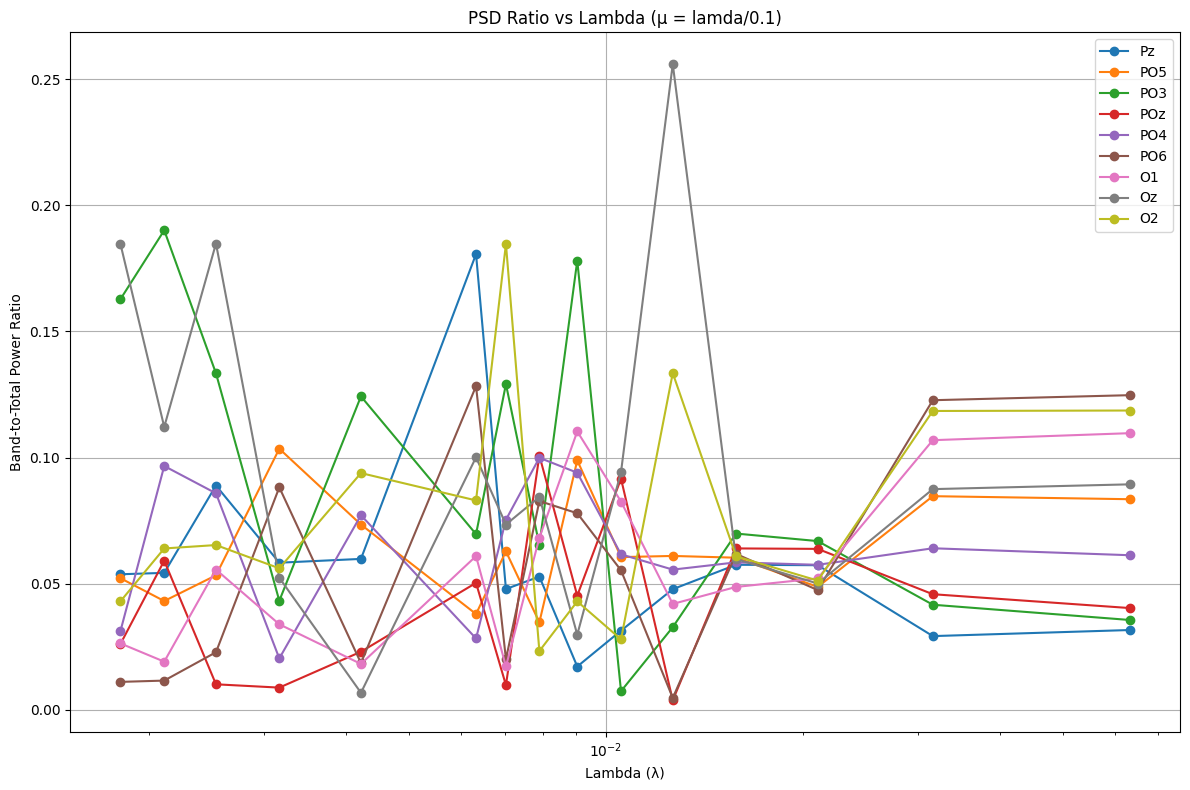

In [11]:
# Define the fixed mu denominator
mu_denominator = 1/10 # 10 times lambda

# Extract lambda values from the grid search
ratio_values = {}

# Initialize ratio_values dictionary with keys for each electrode
for channel_name in selected_channels.keys():
    ratio_values[channel_name] = []

# Collect data from the grid search results
for i, lamb in enumerate(lamb_values):        
    # Get the data for this parameter combination
    X = get_electrodes_data(eeg_data, trial, evoked_frequency, selected_channels, start_sample, end_sample)
    L, S = RPCA(X, lamb, lamb / mu_denominator, tolerance=10e-4, max_iteration=1000)
    
    # Calculate ratios
    original_ratios = calculate_band_to_total_ratio(X)
    L_ratios = calculate_band_to_total_ratio(L)
    
    # Store ratios for each electrode
    for idx, channel_name in enumerate(selected_channels.keys()):
        ratio_values[channel_name].append(L_ratios[idx])

# Sort the data by lambda values
sorted_indices = np.argsort(lamb_values)
lamb_values = [lamb_values[i] for i in sorted_indices]
for channel_name in selected_channels.keys():
    ratio_values[channel_name] = [ratio_values[channel_name][i] for i in sorted_indices]

# Create the plot
plt.figure(figsize=(12, 8))

# Plot a line for each electrode
for channel_name in selected_channels.keys():
    plt.plot(lamb_values, ratio_values[channel_name], marker='o', label=channel_name)

plt.title(f'PSD Ratio vs Lambda (μ = lamda/{mu_denominator})')
plt.xlabel('Lambda (λ)')
plt.ylabel('Band-to-Total Power Ratio')
plt.grid(True)
plt.legend()
plt.xscale('log')  # Use log scale for lambda values if they span multiple orders of magnitude
plt.tight_layout()
plt.show()


### Filtering

In [12]:
print(best_mu, best_lamb)

0.007905694150420948 0.06324555320336758


In [13]:
# Apply CAR filter
CAR_pre_processed_eeg_data = apply_car_filter(eeg_data)

# Apply RPCA
RPCA_L_pre_processed_eeg_data, RPCA_S_pre_processed_eeg_data = apply_rpca_filter(eeg_data, best_lamb, best_mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)

# Apply CAR then RPCA
CAR_RPCA_L_pre_processed_eeg_data, CAR_RPCA_S_pre_processed_eeg_data = apply_rpca_filter(apply_car_filter(eeg_data), best_lamb, best_mu, selected_channels, bci_start_sample, bci_end_sample, evoked_frequencies)

# shapes
print(CAR_pre_processed_eeg_data.shape)
print(RPCA_L_pre_processed_eeg_data.shape)
print(RPCA_S_pre_processed_eeg_data.shape)
print(CAR_RPCA_L_pre_processed_eeg_data.shape)
print(CAR_RPCA_S_pre_processed_eeg_data.shape)



iter: 0, err: 1.1213324150817745, rank L: 9, cardinality of S: 714
iter: 100, err: 0.024690510433059483, rank L: 9, cardinality of S: 2216
iter: 200, err: 0.025798485672605013, rank L: 9, cardinality of S: 2221
iter: 300, err: 0.020757925628791023, rank L: 9, cardinality of S: 2230
iter: 400, err: 0.026724343572806362, rank L: 9, cardinality of S: 2228
iter: 500, err: 0.024434653256422356, rank L: 9, cardinality of S: 2230
iter: 600, err: 0.014918961353869803, rank L: 9, cardinality of S: 2229
iter: 700, err: 0.029461362544944827, rank L: 9, cardinality of S: 2223
iter: 800, err: 0.014445059527925073, rank L: 9, cardinality of S: 2232
iter: 900, err: 0.009164242593394262, rank L: 9, cardinality of S: 2235
iter: 0, err: 1.0157845087370032, rank L: 9, cardinality of S: 710
iter: 100, err: 0.02765308785879201, rank L: 9, cardinality of S: 2219
iter: 200, err: 0.016531053765823603, rank L: 9, cardinality of S: 2226
iter: 300, err: 0.01993862244692642, rank L: 9, cardinality of S: 2224
iter

### Power Spectral Density

In [14]:
# Calculate ratios for original data and filtered components
data_matrix = get_electrodes_data(eeg_data, trial, evoked_frequency, selected_channels, start_sample, end_sample)
CAR_data_matrix = apply_car_filter(eeg_data)
CAR_data_matrix = CAR_data_matrix[list(selected_channels.values()), start_sample:end_sample]

# Calculate band-to-total power ratios
original_ratios = calculate_band_to_total_ratio(data_matrix)
CAR_ratios = calculate_band_to_total_ratio(CAR_data_matrix)
L_ratios = calculate_band_to_total_ratio(RPCA_L_pre_processed_eeg_data[list(selected_channels.values()), :, :, :])
S_ratios = calculate_band_to_total_ratio(RPCA_S_pre_processed_eeg_data[list(selected_channels.values()), :, :, :])

# Display the table of band-to-total power ratios
ratios_table = display_power_ratios_table(original_ratios, L_ratios, S_ratios, CAR_ratios, list(selected_channels.keys()))
print("Band-to-total power ratios for each channel:")
print(ratios_table)

Band-to-total power ratios for each channel:
Channel             Pz       PO5       PO3       POz       PO4       PO6  \
Component                                                                  
Original      0.032105  0.082702  0.034709  0.039103  0.061197  0.125044   
CAR Filtered  0.098961  0.095652  0.100987  0.102922  0.095960  0.097023   
L component   0.102010  0.105157  0.100885  0.102764  0.103218  0.107585   
S component   0.101893  0.105966  0.100911  0.102678  0.103118  0.107528   

Channel             O1        Oz        O2  
Component                                   
Original      0.109949  0.089919  0.118187  
CAR Filtered  0.122120  0.117062  0.119445  
L component   0.112255  0.110229  0.112690  
S component   0.113381  0.110619  0.113717  


## Feature Extraction

In [15]:
# Create label representations for classification
# Y_vector: 1D array with class labels (e.g., [0, 1, 2, 0, 1, ...])
Y_vector = get_label_vector(evoked_frequencies)

# Y_matrix: One-hot encoded matrix representation of labels
# (e.g., [[1,-1,-1], [-1,1,-1], [-1,-1,1], [1,-1,-1], ...])
Y_matrix = get_label_matrix(evoked_frequencies)

In [16]:
# Feature extraction from CAR filtered data
X_CAR = get_feature_matrix_from_eeg_time_domain(CAR_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

# Feature extraction from RPCA low-rank component
X_RPCA_L = get_feature_matrix_from_eeg_time_domain(RPCA_L_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

# Feature extraction from RPCA sparse component
X_RPCA_S = get_feature_matrix_from_eeg_time_domain(RPCA_S_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

# Feature extraction from CAR+RPCA low-rank component
X_CAR_RPCA_L = get_feature_matrix_from_eeg_time_domain(CAR_RPCA_L_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

# Feature extraction from CAR+RPCA sparse component
X_CAR_RPCA_S = get_feature_matrix_from_eeg_time_domain(CAR_RPCA_S_pre_processed_eeg_data, evoked_frequencies, selected_channels, bci_start_sample, bci_end_sample, select_first_harmonic=True)

# Make feature matrix list for all preprocessing methods
X_LIST = [X_CAR, X_RPCA_L, X_RPCA_S, X_CAR_RPCA_L, X_CAR_RPCA_S]

Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)
Windowed data: (5, 9, 250, 40, 6)
Feature Matrix: (120, 72)


## Train and Validation

### Dividing into train and validation data

In [17]:
# Split data into training (80%) and validation (20%) sets for each preprocessing method
# Stratify by Y_vector to ensure balanced class distribution
X_training_list = []
X_validation_list = []

for i, X in enumerate(X_LIST):
    X_train, X_val, \
    Y_vector_train, Y_vector_val, \
    Y_matrix_train, Y_matrix_val = train_test_split(
        X,
        Y_vector,
        Y_matrix,
        test_size=0.2,
        stratify=Y_vector,
        random_state=42  # For reproducibility
    )
    
    X_training_list.append(X_train)
    X_validation_list.append(X_val)
    
    # Store Y values only once (they're the same for all preprocessing methods)
    if i == 0:
        Y_vector_training, Y_vector_validation = Y_vector_train, Y_vector_val
        Y_matrix_training, Y_matrix_validation = Y_matrix_train, Y_matrix_val

# Verification of dimensions
preprocessing_methods = ["CAR", "RPCA_L", "RPCA_S", "CAR_RPCA_L", "CAR_RPCA_S"]

for i, method in enumerate(preprocessing_methods):
    print(f"\n--- {method} Preprocessing ---")
    print(f"X Training: {X_training_list[i].shape}, X Validation: {X_validation_list[i].shape}")

print("\n--- Labels ---")
print("Y_vector Validation:", Y_vector_validation.shape)
print("Y_matrix Validation:", Y_matrix_validation.shape)
print("Y_vector Training:", Y_vector_training.shape)
print("Y_matrix Training:", Y_matrix_training.shape)



--- CAR Preprocessing ---
X Training: (96, 72), X Validation: (24, 72)

--- RPCA_L Preprocessing ---
X Training: (96, 72), X Validation: (24, 72)

--- RPCA_S Preprocessing ---
X Training: (96, 72), X Validation: (24, 72)

--- CAR_RPCA_L Preprocessing ---
X Training: (96, 72), X Validation: (24, 72)

--- CAR_RPCA_S Preprocessing ---
X Training: (96, 72), X Validation: (24, 72)

--- Labels ---
Y_vector Validation: (24,)
Y_matrix Validation: (24, 4)
Y_vector Training: (96,)
Y_matrix Training: (96, 4)


### Model Fitting and Prediction

In [18]:
# Train models for each preprocessing method
least_squares_list = []
lda_list = []
svm_list = []
Y_least_squares_pred_list = []
Y_lda_pred_list = []
Y_svm_pred_list = []

for i, method in enumerate(preprocessing_methods):
    print(f"\nTraining models for {method} preprocessing...")
    
    # Train Least Squares model
    ls = LeastSquares()
    ls.fit(X_training_list[i], Y_matrix_training)
    y_ls_pred = ls.predict(X_validation_list[i])
    least_squares_list.append(ls)
    Y_least_squares_pred_list.append(y_ls_pred)
    
    # Train LDA model
    lda_model = LinearDiscriminantAnalysis()
    lda_model.fit(X_training_list[i], Y_vector_training)
    y_lda_pred = lda_model.predict(X_validation_list[i])
    lda_list.append(lda_model)
    Y_lda_pred_list.append(y_lda_pred)
    
    # Train SVM model
    svm_model = SVC(kernel='linear')
    svm_model.fit(X_training_list[i], Y_vector_training)
    y_svm_pred = svm_model.predict(X_validation_list[i])
    svm_list.append(svm_model)
    Y_svm_pred_list.append(y_svm_pred)



Training models for CAR preprocessing...

Training models for RPCA_L preprocessing...

Training models for RPCA_S preprocessing...

Training models for CAR_RPCA_L preprocessing...

Training models for CAR_RPCA_S preprocessing...


### Final Metrics


Accuracies for CAR preprocessing:
LS Accuracy: 54.17%
LDA Accuracy: 54.17%
SVM Accuracy: 91.67%

Accuracies for RPCA_L preprocessing:
LS Accuracy: 66.67%
LDA Accuracy: 54.17%
SVM Accuracy: 70.83%

Accuracies for RPCA_S preprocessing:
LS Accuracy: 66.67%
LDA Accuracy: 66.67%
SVM Accuracy: 87.50%

Accuracies for CAR_RPCA_L preprocessing:
LS Accuracy: 58.33%
LDA Accuracy: 58.33%
SVM Accuracy: 79.17%

Accuracies for CAR_RPCA_S preprocessing:
LS Accuracy: 70.83%
LDA Accuracy: 70.83%
SVM Accuracy: 100.00%

Results saved to results/model_accuracies.csv
Accuracy comparison chart saved to results/accuracy_comparison_9.png


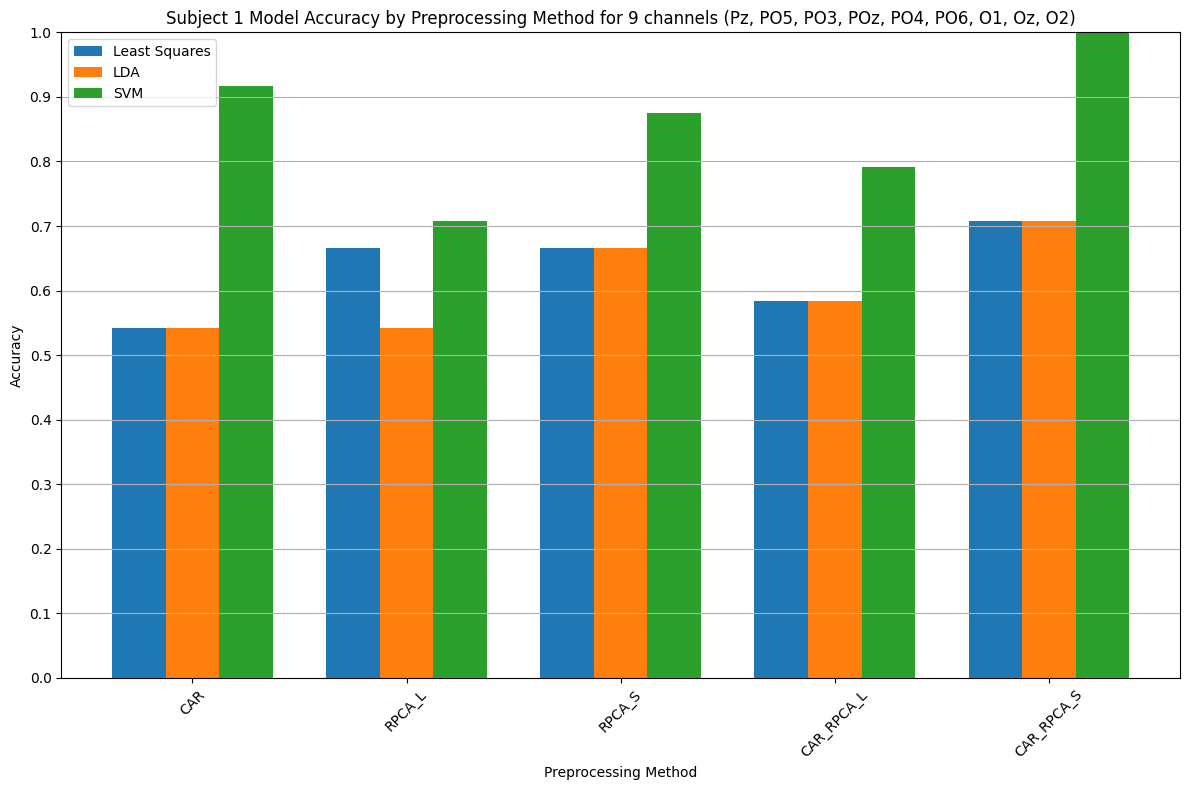

In [20]:
# Calculate and display accuracies for each preprocessing method
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create results directory if it doesn't exist
os.makedirs('code/results', exist_ok=True)

# Initialize lists to store accuracies
ls_accuracies = []
lda_accuracies = []
svm_accuracies = []

# Calculate accuracies for each preprocessing method
for i, method in enumerate(preprocessing_methods):
    ls_acc = accuracy_score(Y_vector_validation, Y_least_squares_pred_list[i])
    lda_acc = accuracy_score(Y_vector_validation, Y_lda_pred_list[i])
    svm_acc = accuracy_score(Y_vector_validation, Y_svm_pred_list[i])
    
    ls_accuracies.append(ls_acc)
    lda_accuracies.append(lda_acc)
    svm_accuracies.append(svm_acc)
    
    print(f"\nAccuracies for {method} preprocessing:")
    print(f"LS Accuracy: {ls_acc * 100:.2f}%")
    print(f"LDA Accuracy: {lda_acc * 100:.2f}%")
    print(f"SVM Accuracy: {svm_acc * 100:.2f}%")

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Preprocessing Method': preprocessing_methods,
    'Least Squares Accuracy': [acc * 100 for acc in ls_accuracies],
    'LDA Accuracy': [acc * 100 for acc in lda_accuracies],
    'SVM Accuracy': [acc * 100 for acc in svm_accuracies]
})

# Save results to CSV
results_df.to_csv('results/model_accuracies.csv', index=False)
print(f"\nResults saved to results/model_accuracies.csv")

# Create bar chart
plt.figure(figsize=(12, 8))
x = np.arange(len(preprocessing_methods))
width = 0.25

plt.bar(x - width, ls_accuracies, width, label='Least Squares')
plt.bar(x, lda_accuracies, width, label='LDA')
plt.bar(x + width, svm_accuracies, width, label='SVM')

plt.xlabel('Preprocessing Method')
plt.ylabel('Accuracy')
plt.title(f'Subject {subject} Model Accuracy by Preprocessing Method for {len(selected_channels)} channels ({", ".join(selected_channels.keys())})')
plt.xticks(x, preprocessing_methods, rotation=45)
plt.ylim(0, 1.0)
plt.yticks(np.arange(0, 1.1, 0.1))  # Set y-ticks with 0.1 step
plt.grid(axis='y')  # Add horizontal grid lines
plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig(f'results/accuracy_comparison_{len(selected_channels)}.png')
print(f"Accuracy comparison chart saved to results/accuracy_comparison_{len(selected_channels)}.png")

# Display the plot
plt.show()
